# Sampling from Truncated Distributions [2] 

In the previous post I indicated that inference with truncated distributions can be executed with Monte Carlo sampling as a first step. I skimmed over the technical details however. This post and every next one will focus on such methods and their application for sampling from truncated multivariate normal distributions.

### Example in two dimensions

To showcase a number of methods to sample from truncated multivariate normal distributions, I will use the example from [1]. This example also concerns sampling in 2 dimensions, as in the previous post. A key difference is however that the feasible region, i.e. the region with non-zero density, is rather narrow. Such a narrow feasible region makes sampling particularly challenging. It is also telling that some of the latest academic research, i.e. [1], was only published in 2014. The next pieces of code load all the packages and then produce a figure showing the sampled density and its mode.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cvx
from os import path
import sys

sys.path.append(path.abspath(path.join(path.abspath('') ,"../../truncsample")))

from truncsample.tmvn import truncmvn

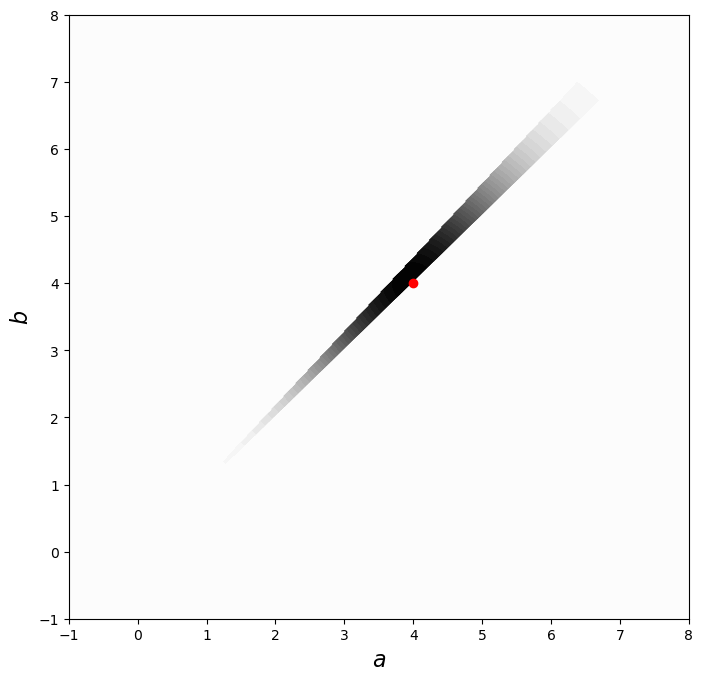

In [2]:
F       =   np.array([[-1,+1],[+1.1,-1]])
g       =   np.array([1,1])*0
mu      =   np.array([+4,+4])
M       =   np.array([[+1,0],[0,+1]])
cov     =   True 

TMVN    =   truncmvn(mu, M, F, g, cov)

mode    =   TMVN.getmode()

a       =   np.linspace(-1,+8,512);
b       =   np.linspace(-1,+8,512);

na      =   len(a)
nb      =   len(b)
N       =   2
sigpar  =   1

L       =   np.zeros([nb,na])
for ia in range(0,na):
    for ib in range(0,nb):
        x   =   np.array([a[ia],b[ib]])
        if np.all (F.dot (x) + g > 0):
            L[ib,ia]   =   np.exp(-( (x[0]-mu[0])**2 +(x[1]-mu[1])**2 )/(2*sigpar*N) - 1/2*np.log(2*np.pi) - 1/2*np.log(sigpar**2) ) 
        else :
            L[ib,ia]   =   0
        
cmap    =   plt.cm.get_cmap("gray")

fig     =   plt.figure(figsize=(8,8),dpi=100)
ax      =   fig.gca()
ax.contourf(a, b,-L/np.max(L),42,cmap='gray')
plt.plot(mode[0],mode[1],'ro')
ax.set_xlabel('$a$', fontsize=16)
ax.set_ylabel('$b$', fontsize=16)
plt.axis('tight');


### Rejection sampler

#### Basic method

One of the easiest samplers to understand is the rejection sampler. In this case, one essentially samples from the multivariate distribution without truncation and simply removes all the samples that are outside of the feasible region. The next figure shows how this works for the chosen example. All the considered samples are shown as dots. The accepted ones are shown in blue while the rejected ones are shown in red. One continues sampling until the number of accepted samples reaches the requested number of samples. For this example, the acceptance rate hovers around 11% so that approximately 9000 samples need to be tested to obtain 1000 accepted samples.

trunc.tmvn.sampling ...
... rejection sampler
... rejection sampler - trials: 2000 - successes: 217
... rejection sampler - trials: 9217 - successes: 982
... rejection sampler - trials: 9386 - successes: 1000
... rejection sampler - observed success rate [%]: 10.655
trunc.tmvn.sampling finished


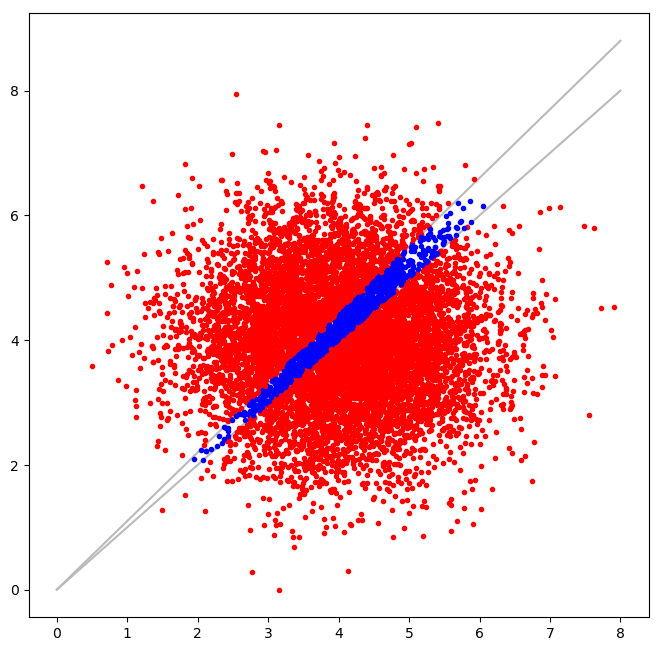

In [3]:
K = 1000
linvF = np.linalg.pinv(F)
u_ = np.linspace(0,.8,2)

fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.gca()
plt.plot(linvF[0,1]*u_,linvF[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF[1,1]*u_,linvF[1,0]*u_,'-',Color=np.ones(3)*.73)

samples_rej,bnc =    TMVN.sample(K,sampler="rejection",verbose=True,visual=True)


#### An intuition

One way to imagine the sampling process in this example is to think of a person shooting arrows at a rose. This person shoots arrows according to a spherical multivariate normal distribution with the middle of the rose as the mean. Between the archer and the rose stands a glass panel with a narrow opening in it. As a result, only a fraction of the shot arrows actually arrive at the rose and many arrows bounce of the glass panel. The distribution of the arrows arriving at the rose is then the truncated multivariate distribution we are after.

#### Performance

The next figure shows a set of 1000 accepted samples in three panels. The top-left panel show the samples in the 2-dimensional plane as above. The top-right panel shows the second coordinate as a function of the sample index while the bottom-left panel shows the first coordinate as a function of the sample index. What this figure demonstrates quite nicely is that the obtained samples exhibit no auto-correlation, which is desirable for any sampling method.

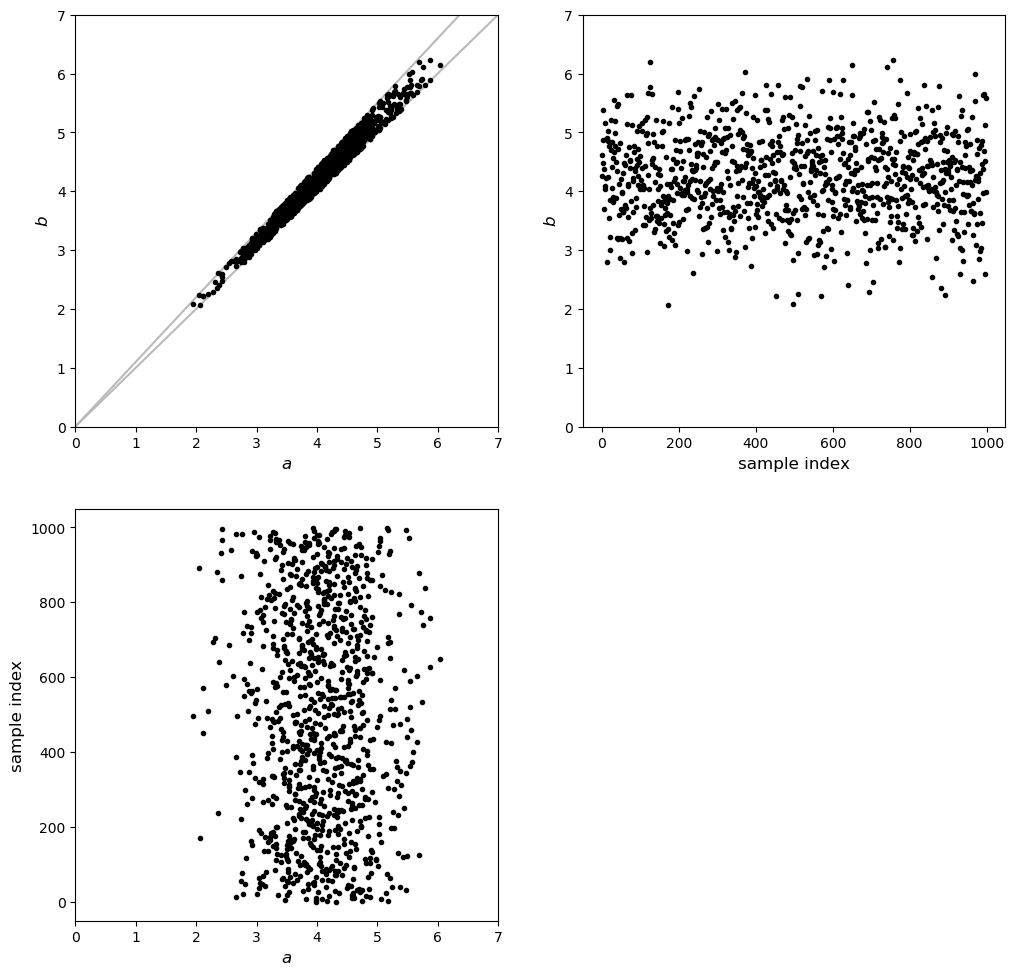

In [4]:
fig     =    plt.figure(figsize=(12,12),dpi=100);
fig.add_subplot(221);
ax = fig.gca()
plt.plot(linvF[0,1]*u_,linvF[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF[1,1]*u_,linvF[1,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(samples_rej[0,:],samples_rej[1,:],'k.')
ax.set_xlim((0, +7))
ax.set_ylim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(222);
ax = fig.gca()
plt.plot(np.arange(K),samples_rej[1,:],'k.')
ax.set_ylim((0, +7))
ax.set_xlabel('sample index', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(223);
ax = fig.gca()
plt.plot(samples_rej[0,:],np.arange(K),'k.')
ax.set_xlim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('sample index', fontsize=12);

#### Summary

The most important benefits and drawbacks of rejection sampling are:

* Advantages:

    * Fairly easy to understand as a two-step shoot and accept/reject process

    * No autocorrelation between the samples

    * Feasible region can easily take any form, i.e. does not have to be convex or polyhedral (not demonstrated)

* Disadvantages:

    * Efficiency can be low when the feasible region is very narrow or has low density (demonstrated in a future post)

    * Since the efficiency is unknown a priori, it is difficult to estimate the time needed for the required number of samples before running the sampler

### Gibbs sampler

#### Basic method

I first read about this Gibbs sampler for truncated distributions in [1]. The essence of the Gibbs sampler is as follows. Consider a given initial parameter set, called a seed (${\mathbf\theta}_0$). Starting with this seed, follow these steps:

1. Make a copy of the current parameter set (${\mathbf\theta}_{k+1} \leftarrow {\mathbf\theta}_k$). 

2. Consider that all parameters in this set are fixed except one (with index $j$: ${\mathbf\theta}_k(j)$). The distribution of this one parameter, conditional to the values of the fixed parameters, is a truncated univariate normal distribution. Now sample from this distribution to obtain a new value, $\theta^*$. This is fairly easy to do.

3. Replace the original parameter value with the new one: ${\mathbf\theta}_k(j) \leftarrow \theta^*$. 

4. Go back to step 2 until all parameter values have been replaced ($j=1,...,D$), with $D$ the number of dimensions. In the example $D$ equals 2. 

5. Go back to step 1 until $k$ has reached a target number of samples

The Gibbs sampler is a first of three Markov Chain Monte Carlo (MCMC) methods I am testing. All MCMC methods share the property that the series of samples are autocorrelated. The magnitude of this autocorrelation depends on the sampler and the exact distribution that is sampled from. Another feature of the considered MCMC methods is that every sample is retained, i.e. there are no rejections. This means one can know in advance how many iterations are necessary until the target number of samples is reached. The Gibbs sampler is fairly easy to implement. It consists of two nested loops and sampling from a truncated univariate normal distribution at its core. To sample from the truncated univariate normal distribution, I use the *truncnorm* class in *scipy.stats*.

The next figure shows how the first 7 samples are obtained in the example. Starting with the seed (red dot), the algorithm changes the first coordinate first and then the second coordinate (grey lines). At the end of this, a new sample is produced (black dot). This is repeated 6 times to produce 6 new samples (black dots).

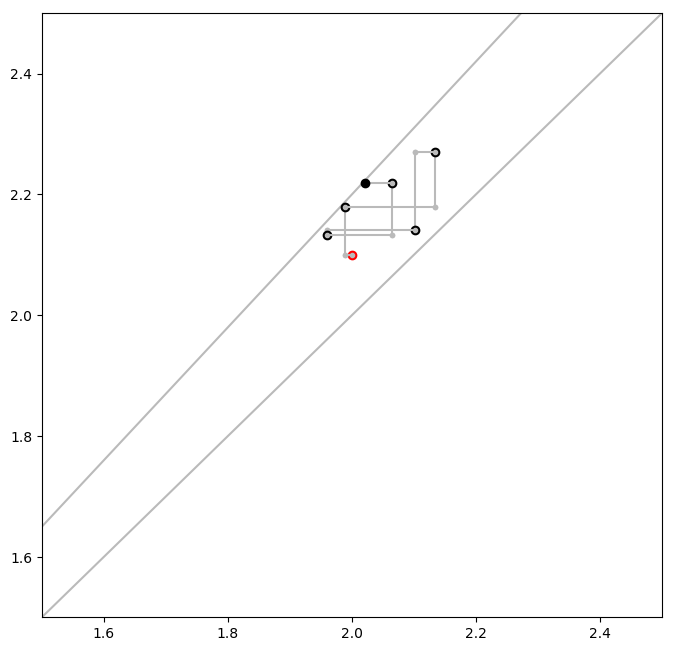

In [5]:
ystart = np.array([+2,+2.1])
K=7
u_ = np.linspace(0,.8,2)

fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.gca()
plt.plot(linvF[0,1]*u_,linvF[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF[1,1]*u_,linvF[1,0]*u_,'-',Color=np.ones(3)*.73)
ax.set_xlim((1.5, 2.5))
ax.set_ylim((1.5, 2.5))

np.random.seed(42)
samples_gibbs =      TMVN.sample(K,ystart,sampler="gibbs",verbose=False,visual=True)

#### Performance

The next figure shows the biplot and the trace plots of 1000 samples obtained by Gibbs sampling. One can see in the trace plots that the autocorrelation between samples is quite high. This is because the inequality constraints strongly restrict the movement of one sample to the next sample.

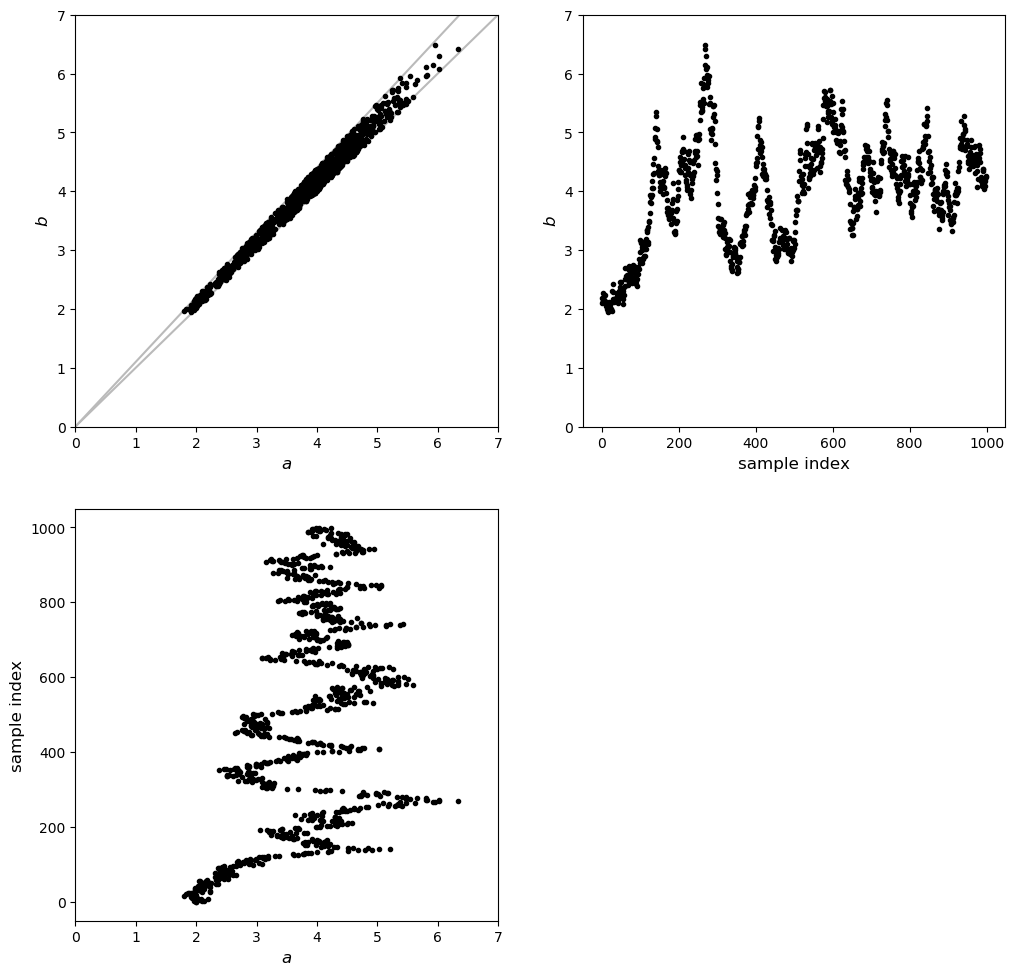

In [6]:
K=1000
np.random.seed(42)
samples_gibbs,bnc =      TMVN.sample(K,ystart,sampler="gibbs",verbose=False,visual=False)
fig     =    plt.figure(figsize=(12,12),dpi=100);
fig.add_subplot(221);
ax = fig.gca()
plt.plot(linvF[0,1]*u_,linvF[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF[1,1]*u_,linvF[1,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(samples_gibbs[0,:],samples_gibbs[1,:],'k.')
ax.set_xlim((0, +7))
ax.set_ylim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(222);
ax = fig.gca()
plt.plot(np.arange(K),samples_gibbs[1,:],'k.')
ax.set_ylim((0, +7))
ax.set_xlabel('sample index', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(223);
ax = fig.gca()
plt.plot(samples_gibbs[0,:],np.arange(K),'k.')
ax.set_xlim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('sample index', fontsize=12);

#### Summary

The most important benefits and drawbacks of Gibbs sampling are:

* Advantages:

    * Relatively easy to implement

    * No rejected samples

    * Feasible region does not have to be convex or polyhedral as long one can sample from the conditional univariate distribution (not demonstrated)

    * The computational time is linear in the number of samples

* Disadvantages:

    * Gibbs sampling can result in strong autocorrelation between consecutive samples

    * The computational time increases linearly in the number of dimensions (not demonstrated)

    * Getting an intuition as to why and how the Gibbs sampler works is not easy.

    * The quality of the chain of samples, particulary convergence and autocorrelation, may depend strongly on the chosen coordinate system.

### Hit-and-run sampler

#### Basic method

The hit-and-run sampler can be tought of as a generalization of the Gibbs sampler. This one is described here [2]. Starting with a seed, the Hit-and-Run sampler follows these steps:

1. Pick a random direction in the $D$-dimensional space by sampling a single $D$-dimensional random vector ${\mathbf v}$ from a spherical multivariate normal distribution.

2. Identify the line described by the current sample (${\mathbf\theta}_{k}$) and the selected direction (${\mathbf v}$) using $u$ as the coordinate: ${\mathbf \theta}(u) = {\mathbf v} u + {\mathbf\theta}_{k}$

3. Compute the density of $u$ as the density that arises from evaluating the sampled density along the identified line described above (conditional density).

4. Sample a value for $u$ from the identified univariate distribution and call this value $u^*$. 

5. Identify the $k$th sample as ${\mathbf\theta}_{k+1}:= {\mathbf v} u^* + {\mathbf\theta}_{k}$

6. Go back to step 1 until $k$ has reached a target number of samples

Whereas the Gibbs sampler only applies moves along the coordinate axes, the hit-and-run sampler can move in every direction. A possible advantage of this is that the resulting chain of samples does not depend anymore on the coordinate system that the distribution is specified in. In addition, I expect the computational effort per sample to increase only marginally with the number of dimensions $D$. The first and third step may be affected somewhat by the dimensionality but there are highly efficient routines available for these steps.

The next figure shows how the first 7 samples are obtained for the example. Starting with the seed (red dot), the algorithm iteratively finds a new direction and computes the feasible section of this line (grey lines). The density along this line is then computed. The grey dots are the modes of this distribution in absence of inequality constraints. These unconstrained modes are computed as the orthogonal projections of the multivariate mean (blue dot) to the identified line. One can also see that these modes can lie outside of the feasible region. Each time, a new sample is obtained from the (truncated, univariate) density along the identified line (black dot). This is repeated 6 times to produce 6 new samples.

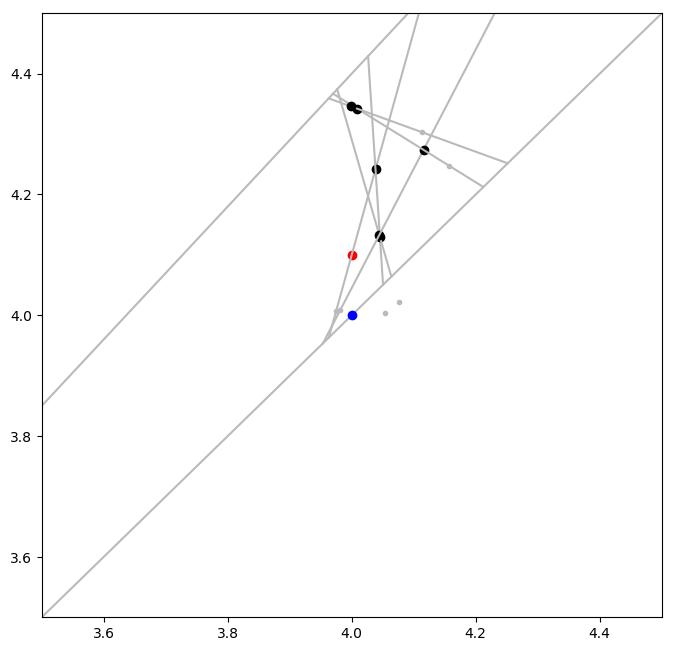

In [7]:
ystart = np.array([+4,+4.1])
K=7
u_ = np.linspace(0,.8,2)

fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.gca()
plt.plot(linvF[0,1]*u_,linvF[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF[1,1]*u_,linvF[1,0]*u_,'-',Color=np.ones(3)*.73)
ax.set_xlim((3.5, 4.5))
ax.set_ylim((3.5, 4.5))
plt.plot(mu[0],mu[1],'bo')

np.random.seed(73)
samples_hitandrun,bnc =      TMVN.sample(K,ystart,sampler="hitandrun",verbose=False,visual=True)

#### Performance

The next figure shows the biplot and the trace plots of 1000 samples obtained by hit-and-run sampling. One can see in the trace plots that there is autocorrelation between samples as in the case of the Gibbs sampler. However, to the naked eye, it looks like the hit-and-run reaches the mode of the dsitribution faster and that the autocorrelation is slightly weaker compared to the Gibbs sampling case (shown in grey).

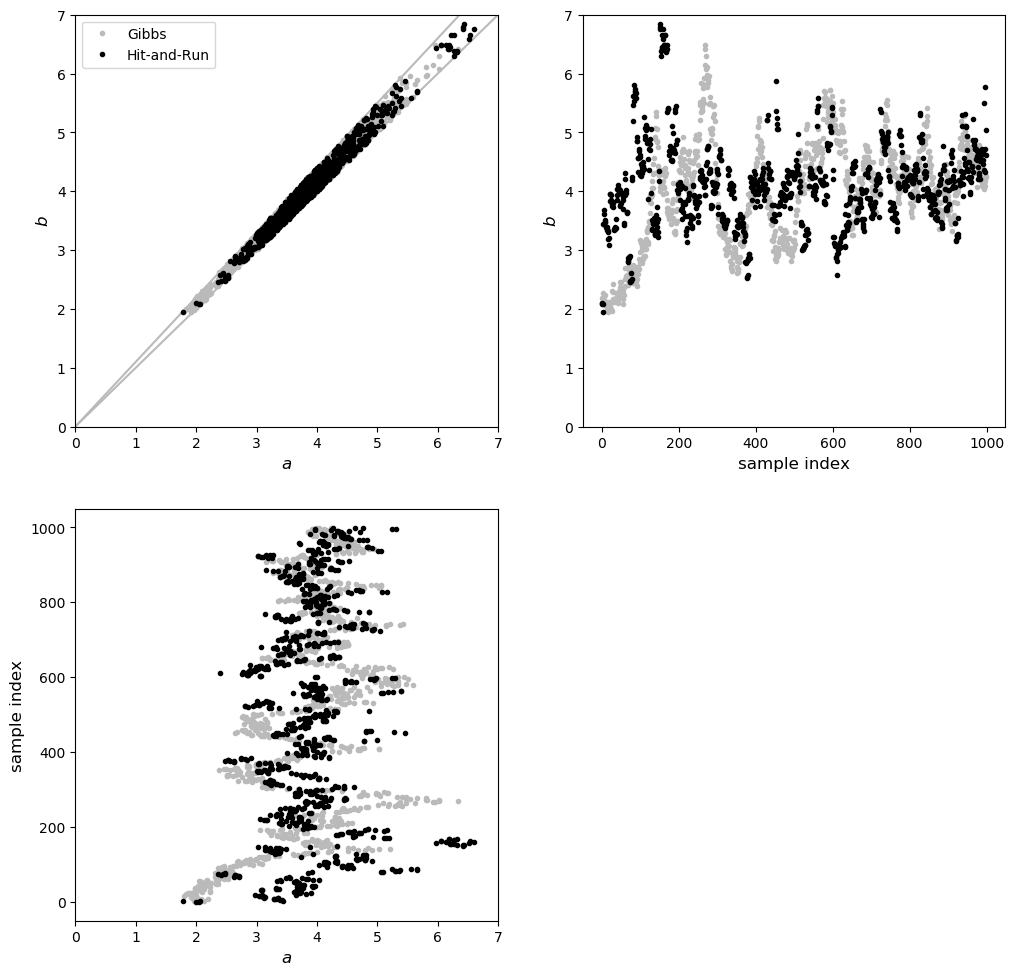

In [8]:
K=1000

np.random.seed(42)
ystart = np.array([+2,+2.1])
samples_hitandrun,bnc =      TMVN.sample(K,ystart,sampler="hitandrun",verbose=False,visual=False)
fig     =    plt.figure(figsize=(12,12),dpi=100);
fig.add_subplot(221);
ax = fig.gca()
plt.plot(linvF[0,1]*u_,linvF[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF[1,1]*u_,linvF[1,0]*u_,'-',Color=np.ones(3)*.73)
h1, = plt.plot(samples_gibbs[0,:],samples_gibbs[1,:],'k.',Color=np.ones(3)*.73,label='Gibbs')
h2, = plt.plot(samples_hitandrun[0,:],samples_hitandrun[1,:],'k.',label='Hit-and-Run')
ax.set_xlim((0, +7))
ax.set_ylim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
plt.legend(handles=[h1,h2]);
fig.add_subplot(222);
ax = fig.gca()
plt.plot(np.arange(K),samples_gibbs[1,:],'k.',Color=np.ones(3)*.73)
plt.plot(np.arange(K),samples_hitandrun[1,:],'k.')
ax.set_ylim((0, +7))
ax.set_xlabel('sample index', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(223);
ax = fig.gca()
plt.plot(samples_gibbs[0,:],np.arange(K),'k.',Color=np.ones(3)*.73)
plt.plot(samples_hitandrun[0,:],np.arange(K),'k.')
ax.set_xlim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('sample index', fontsize=12);

#### Summary

The most important benefits and drawbacks of hit-and-run sampling are:

* Advantages:

    * No rejected samples

    * Feasible region does not have to be convex or polyhedral as long one can sample from the conditional univariate distribution (not demonstrated)

    * The result does not depend on the chosen coordinate system

    * The computational time is linear in the number of samples

    * The computational time is practically constant with respect to the number of dimensions (not demonstrated)

* Disadvantages:

    * The implementation was slightly trickier as it required me to review some linear matrix algebra

    * Hit-and-run sampling can result in strong autocorrelation between consecutive samples

    * Getting an intuition as to why and how the hit-and-runsampler works is not easy.

### Hamiltonian Monte Carlo sampler (also: Hybrid Monte Carlo sampler)

#### Basic method

The third MCMC sampler I want to showcase is the Hamiltonian Monte Carlo (HMC) sampler, sometimes also known as the Hybrid Monte Carlo sampler. 

Starting from a seed, HMC proceeds as follows:

1. Pick a random direction in the $D$-dimensional space by sampling a single $D$-dimensional random vector ${\mathbf v}$ from a spherical multivariate normal distribution and set $y := {\mathbf\theta}_{k}$.

2. Identify an ellipsoidal trajectory around the mean $\mu$ by taking the current sample ($y$) as the start point and the selected direction (${\mathbf v}$) as the direction of the tangent to the ellipsoid, using $u$ as the position along the ellipsoid (ranging from 0 to 2$\pi$ to describe one full turn). Using $a$ and $b$ for the first and second coordinate, one can write:

    * $a(u) =   v(1)  \sin (u)   +   (y(1)-\mu(1))  \cos (u)$
    
    * $b(u) =   v(2)  \sin (u)   +   (y(1)-\mu(2))  \cos (u)$
    
3. Choose a value for $\tau^*$ (details below) and set $\tau := \tau^*$.

4. Identify whether travelling along the ellipsoid from $u=0$ to $u=\tau$ means that the feasible region has been left (yes/no) and

    * If yes: execute the reflection procedure described below.

    * If no: Identify the $k+1$th sample as ${\mathbf\theta}_{k} := {\mathbf v} \sin(\tau) + (y-\mu) \cos (\tau)$ and go back to step 1 until $k$ has reached a target number of samples

Clearly, the HMC is a more complex method compared to the previous two MCMC samplers. The current implementation is based on Matlab code from [4] which I modified to fit the *truncsample* Python package. Initially, I worked with my own version starting from the corresponding article [3]. Getting the computational details straight proved not easy however and adapting the implementation [4] has been a more reliable choice.

#### Reflection procedure

A. Compute the lowest value for $u$ where the ellipsoid crosses the boundary of the feasible region and call this value $u^*$. 
        
B. Redefine

* $\mathbf y$ as ${\mathbf y} \leftarrow {\mathbf v} \sin(u^*) + ({\mathbf y}-{\mathbf \mu}) \cos (u^*)$ 

* $\mathbf v$ as ${\mathbf v} \leftarrow {\mathbf v} \cos(u^*) - ({\mathbf y}-{\mathbf \mu}) \sin (u^*)$

* $\tau$ as $\tau \leftarrow \tau - u^*$

C. Describe the line which includes  $\mathbf y$ and is orthogonal to the boundary of the feasible region as $\mathbf{y} + \mathbf{f} w$ (with $\mathbf{f}$ describing the orthogonal direction and $w$ the coordinate along this line)

D. Modify $\mathbf{v}$ by perfect reflection at the identified point of the boundary: $\mathbf{v} \leftarrow  \mathbf{v} - 2 \cdot {\mathbf f} \cdot {({\mathbf f}^T \cdot {\mathbf f})}^{-1} \cdot {\mathbf f}^T \cdot {\mathbf v}$

E. Go back to step 4
        

#### Choice of $\tau^*$
In the case of truncated multivariate normal distributions, the value of $\tau^*$ can be fixed to a non-random value. By default $\tau^* := \pi/2$, which corresponds to a quarter turn along the ellipsoidal path. Alternative uses of HMC include the option to use a different value for $\tau^*$ or to randomize it for every sample.

The next figure shows how the first 3 samples are obtained for the example. Starting with the seed (red dot), the algorithm computes the path consisting of segments of ellipsoidal trajectories (grey curves) separated by reflections at the boundaries (grey dots). At the end of the path, one finds the new sample (black dot), which is then used as the starting point for the next path.

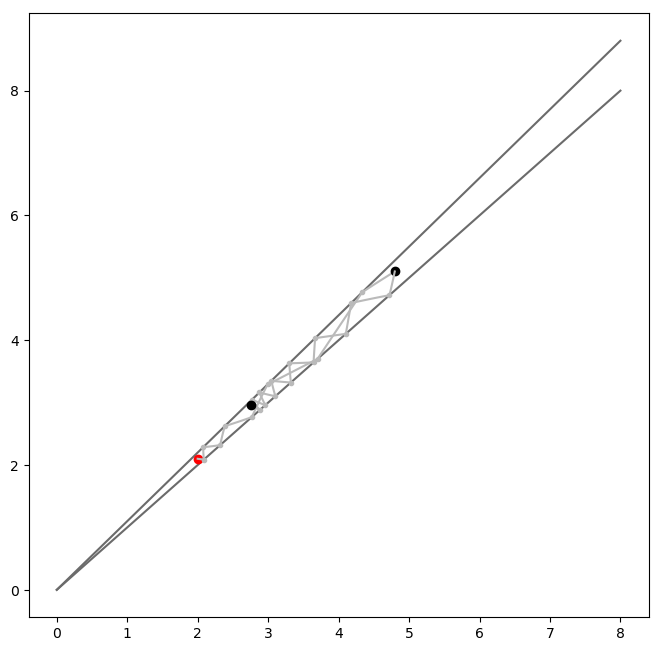

In [9]:
ystart = np.array([+2,+2.1])
K=3
u_ = np.linspace(0,.8,2)

fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.gca()
plt.plot(linvF[0,1]*u_,linvF[0,0]*u_,'-',Color=np.ones(3)*.42)
plt.plot(linvF[1,1]*u_,linvF[1,0]*u_,'-',Color=np.ones(3)*.42)

np.random.seed(11)
samples_hmc =      TMVN.sample(K,ystart,sampler="hmc",verbose=False,visual=True)

#### An intuition

Hamiltonian Monte Carlo is often explained by considering planetary motion as a metaphor. In this case, the mean can be thought of as a star and the ellipsoid as the trajectory of a planet around this star. In this thought experiment, we give the planet a random direction and momentum (step 1) and let the planet turn around its star along its ellipsoidal trajectory (step 2). After some time (e.g., one quarter/season), we halt the planet (step 3/4) and record its position. We then give the planet a new random direction and momentum and proceed. For truncated distributions we must additionally consider the existence of reflecting walls. When the planet reaches these walls it bounces back and then continues with the same speed in a new direction. One can also think of it as a giant billiard table with a heavy object acting as a force pulling on the billiard ball and reflective boundaries modifying the billiard's trajectory with each bounce.

Whether this intuition is easy to grasp and link to the algorithm above will depend a bit on the familiarity with Newtonian physics. Personally, it had to refresh my memory to get a feel for it.

#### Performance

The next figure shows the biplot and the trace plots of 1000 samples obtained by HMC sampling. Although every MCMC sampler will exhibit some autocorrelation, ine can see in the trace plots that - to the naked eye - there is no obvious autocorrelation between the consecutive samples in this case.

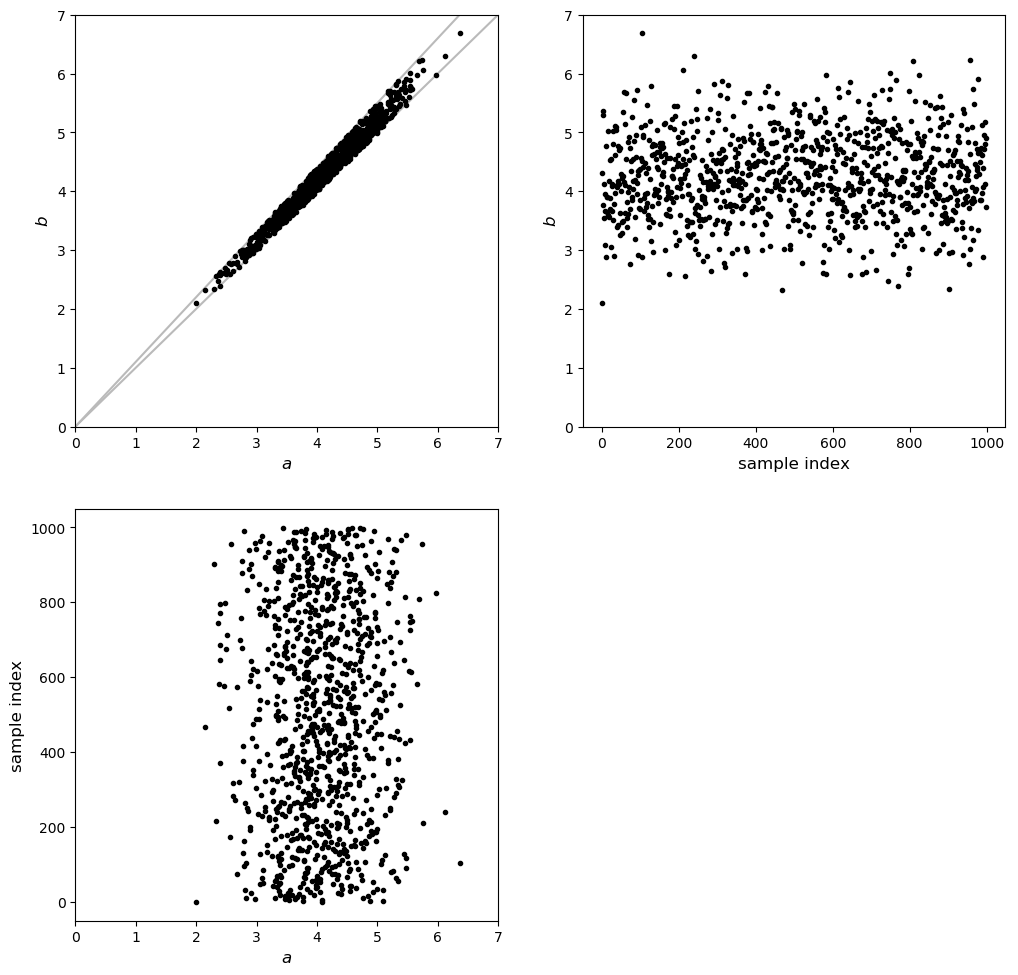

In [10]:
K=1000

np.random.seed(42)
ystart = np.array([+2,+2.1])
samples_hmc,bnc =      TMVN.sample(K,ystart,sampler="hmc",verbose=False,visual=False)
fig     =    plt.figure(figsize=(12,12),dpi=100);
fig.add_subplot(221);
ax = fig.gca()
plt.plot(linvF[0,1]*u_,linvF[0,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(linvF[1,1]*u_,linvF[1,0]*u_,'-',Color=np.ones(3)*.73)
plt.plot(samples_hmc[0,:],samples_hmc[1,:],'k.',label='hit-and-run')
ax.set_xlim((0, +7))
ax.set_ylim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(222);
ax = fig.gca()
plt.plot(np.arange(K),samples_hmc[1,:],'k.')
ax.set_ylim((0, +7))
ax.set_xlabel('sample index', fontsize=12)
ax.set_ylabel('$b$', fontsize=12)
fig.add_subplot(223);
ax = fig.gca()
plt.plot(samples_hmc[0,:],np.arange(K),'k.')
ax.set_xlim((0, +7))
ax.set_xlabel('$a$', fontsize=12)
ax.set_ylabel('sample index', fontsize=12);

### Summary

The most important benefits and drawbacks of HMC sampling are:

* Advantages:

    * No rejected samples

    * Feasible region does not have to be convex or polyhedral as long as one can compute the points and direction of reflection at the boundaries of the feasible region (not demonstrated)

    * The result does not depend on the chosen coordinate system   

    * The computational time is linear in the number of samples

    * The computational time is practically constant with respect to the number of dimensions (not demonstrated)

* Disadvantages:

    * The implementation of HMC for truncated distributions is far from intuitive. It requires a good grasp on matrix algebra and trigonometry. Computationally speaking, I experienced that the chosen method to compute the points of reflection $(u^*)$ can strongly influence the numerical precision of the results. Even when implemented in a robust manner, one must account for the possibility that -on occasion- a new sample may be located in the infeasible region due to lack of numerical precision.

    * Getting an intuitive notion as to why samples obtained with HMC sampling will converge to the target distribution seems challenging to me and probably also for anyone else that is not versed well in statistical mechanics. 

### Take home message

* I implemented a total of 4 methods specifically designed for sampling from a truncated multivariate normal distribution. The first sampler was a Monte Carlo sampler called rejection sampling while the last three were Markov Chain Monte Carlo (MCMC) methods. 

* In the studied two-dimensional example, the HMC method appears most effective on the basis of simple vizualisations of the results. None of the samples are rejected and there is no visible autocorrelation. 

### References

[1] Rodriguez-Yam, G., Davis, R. A., & Scharf, L. L. (2004). Efficient Gibbs sampling of truncated multivariate normal with application to constrained linear regression. Unpublished manuscript.

[2] Chen, M.t, and Deely, J. (1992), Application of a New Gibbs Hit-and-Run Sampler to a Constrained LinearMultiple Regression Problem, Technical Report 92-21, Purdue University, Center for Statistical DecisionSciences and Department of Statistics.

[3] Pakman, A., & Paninski, L. (2014). Exact Hamiltonian Monte Carlo for truncated multivariate Gaussians. Journal of Computational and Graphical Statistics, 23(2), 518-542.

[4] https://github.com/aripakman/hmc-tmg